In [10]:
from transforms import *
from utils.encoding import ClassMapper

from torchvision.datasets import Cityscapes
from datasets import A2D2Dataset

a2d2_root = ".\\data\\a2d2\\"
cityscapes_root = ".\\data\\cityscapes"

#A2D2

from torch.utils.data import Subset
import numpy as np

# mapper = ClassMapper(
#     dataset_class=A2D2Dataset,
#     train_transforms=train_transforms,
#     val_transforms=val_transforms,
#     infer_transforms=test_transforms,
#     reduced_subset=True
#     )

# train_dataset = A2D2Dataset(
#     root=a2d2_root,
#     split='train',
#     transforms=mapper.wrap_train
    
# )

# val_dataset_full = A2D2Dataset(
#     root=a2d2_root,
#     split='val',
#     transforms=mapper.wrap_val
# )

# step = 5  # bierz co 5-tą klatkę
# val_idx = np.arange(0, len(val_dataset_full), step).tolist()
# val_dataset = Subset(val_dataset_full, val_idx)

# checkpoints = [
# '.\\checkpoints\\modern\\stage_t2\\DeepLabV3Plus\\version_4\\checkpoints\\epoch=7-step=39507.ckpt',
# '.\\checkpoints\\modern\\stage_t2\\PAN\\version_10\\checkpoints\\epoch=7-step=39507.ckpt',
# '.\\checkpoints\\modern\\stage_t2\\Linknet\\version_12\\checkpoints\\epoch=7-step=39507.ckpt',
# '.\\checkpoints\\modern\\stage_t2\\Segformer\\version_0\\checkpoints\\epoch=7-step=39507.ckpt'
# ]

# Cityscapes

mapper = ClassMapper(
    dataset_class=Cityscapes,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
    infer_transforms=test_transforms,
    reduced_subset=True
    )

train_dataset = Cityscapes(
    root=cityscapes_root,
    split='train',
    target_type="semantic",
    transforms=mapper.wrap_train
)

val_dataset = Cityscapes(
    root=cityscapes_root,
    split='val',
    target_type="semantic",
    transforms=mapper.wrap_val
)

checkpoints = [
'.\\checkpoints\\modern\\stage_t1\\DeepLabV3Plus\\version_1\\checkpoints\\epoch=49-step=37150.ckpt',
'.\\checkpoints\\modern\\stage_t1\\PAN\\version_8\\checkpoints\\epoch=49-step=37150.ckpt',
'.\\checkpoints\\modern\\stage_t1\\Linknet\\version_6\\checkpoints\\epoch=49-step=37150.ckpt',
'.\\checkpoints\\modern\\stage_t1\\Segformer\\version_1\\checkpoints\\epoch=49-step=37150.ckpt'
]

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from math import ceil
from string import ascii_lowercase

def display_image_and_masks(
        mapper: "ClassMapper",
        image, 
        mask_true=None,
        mask_pred=None,
        *extra_masks,
    ):
    """2 kolumny; u góry obraz (+ opcjonalnie mask_true), niżej maski (mask_pred oraz kolejne),
    podpisy zawsze POD obrazkami. Gdy mask_true brak – obraz zajmuje cały górny rząd (2 kolumny)."""

    # ── NIE RUSZAĆ: sekcja wstępna dokładnie jak podałeś ─────────────────────────
    if isinstance(image, torch.Tensor):
        image = image.cpu().permute(1,2,0).numpy()
    elif isinstance(image, np.ndarray):
        pass
    else:
        raise TypeError(f"Unsupported image type: {type(image)}")

    n_images = 1
    if mask_true is not None:
        n_images += 1
    if mask_pred is not None:
        n_images += 1

    k_image = 1
    # ─────────────────────────────────────────────────────────────────────────────

    # ── Pomocniczo: etykiety (a), (b), ... (aa), ... ────────────────────────────
    def letter_tag(idx: int) -> str:
        s, i = "", idx
        while True:
            s = ascii_lowercase[i % 26] + s
            i = i // 26 - 1
            if i < 0: break
        return f"({s})"

    # ── Lista masek do dolnej siatki + podpisy ──────────────────────────────────
    gallery, captions = [], []
    seq = []
    if mask_pred is not None:
        seq.append(("mask_pred", mask_pred))
    for j, m in enumerate(extra_masks):
        seq.append((f"extra_{j}", m))

    for i, (_, m) in enumerate(seq):
        m_rgb = mapper.apply_mask_mapping(mask=m)
        gallery.append(m_rgb)
        captions.append(letter_tag(i))

    # ── Siatka: 2 kolumny ───────────────────────────────────────────────────────
    n_cols = 2
    rows_below = ceil(len(gallery) / n_cols) if gallery else 0
    n_rows_total = 1 + rows_below

    fig_height_per_row = 4.0
    fig = plt.figure(
        figsize=(12, max(4.0, fig_height_per_row * n_rows_total)),
        dpi=150,
        constrained_layout=True
    )
    gs = fig.add_gridspec(nrows=n_rows_total, ncols=n_cols, hspace=0.00, wspace=0.02)

    # ── Górny rząd ───────────────────────────────────────────────────────────────
    img_np = np.clip(image, 0, 1)

    def put_caption_below(ax, text, pad=0.03, fontsize=16):
        # Tekst tuż POD obrazkiem (współrzędne osi), zawsze widoczny
        ax.text(0.5, -pad, text, transform=ax.transAxes, ha='center', va='top',
                fontsize=fontsize, clip_on=False)

    if mask_true is not None:
        ax_img = fig.add_subplot(gs[0, 0])
        ax_img.imshow(img_np, interpolation='lanczos')
        ax_img.axis('off')
        put_caption_below(ax_img, "Obraz")

        mask_true_rgb = mapper.apply_mask_mapping(mask=mask_true)
        ax_true = fig.add_subplot(gs[0, 1])
        ax_true.imshow(mask_true_rgb, interpolation='none')
        ax_true.axis('off')
        put_caption_below(ax_true, "Maska rzeczywista")
    else:
        ax_img = fig.add_subplot(gs[0, :])
        ax_img.imshow(img_np, interpolation='lanczos')
        ax_img.axis('off')
        put_caption_below(ax_img, "Obraz")

    # ── Dolne rzędy (maski) ─────────────────────────────────────────────────────
    idx = 0
    for r in range(1, n_rows_total):
        for c in range(n_cols):
            if idx >= len(gallery):
                break
            ax = fig.add_subplot(gs[r, c])
            ax.imshow(gallery[idx], interpolation='none')
            ax.axis('off')
            put_caption_below(ax, captions[idx])
            idx += 1

    # odrobina luzu na napisy
    try:
        fig.set_constrained_layout_pads(hspace=0.02, wspace=0.01)
    except Exception:
        pass

    plt.show()


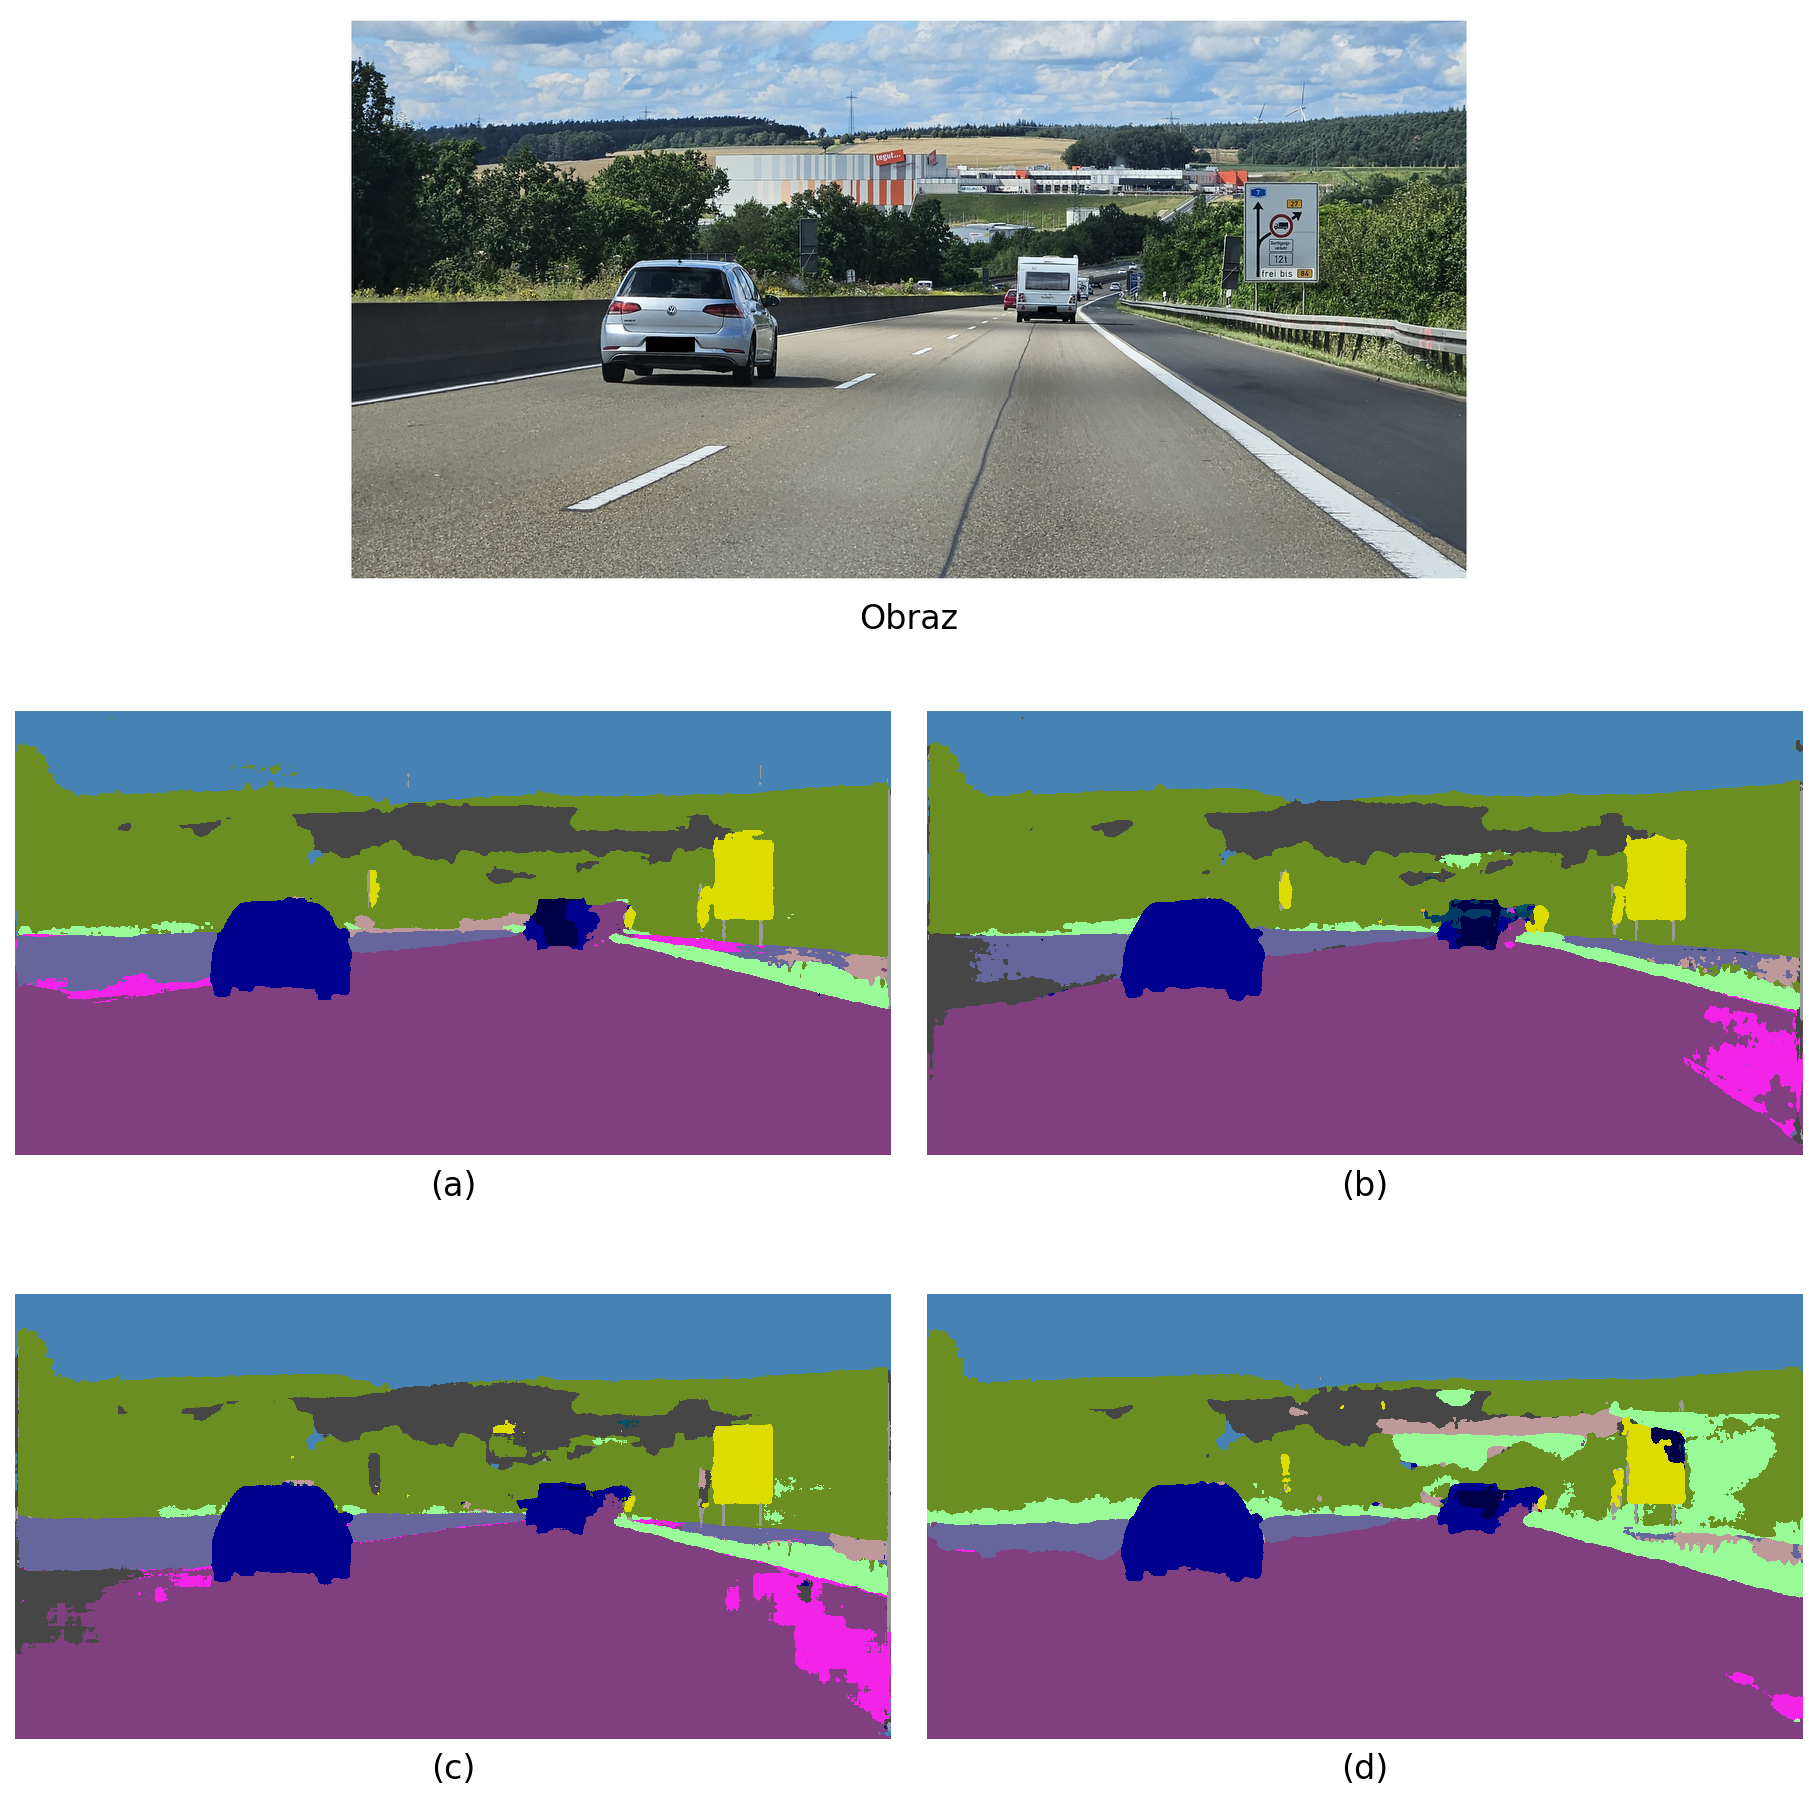

In [12]:
import torch
from utils.image import *
from PIL import Image
from training.model import ExperimentalModel


import segmentation_models_pytorch as smp

preds = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for ckpt in checkpoints:

    model = ExperimentalModel.load_from_checkpoint(
        checkpoint_path=ckpt,
        weights="imagenet",
        in_channels=3,
        mapper=mapper
    )

    model = model.to(device)

    pil_image = Image.open(r".\\test\\test7.png").convert("RGB")

    aug_image = mapper.preprocess_image(img=np.asarray(pil_image))
    tensor_image = aug_image.to(device)

    model.eval() 

    with torch.inference_mode():
        logits = model(tensor_image)
        
    pr_mask = logits.softmax(1).argmax(1)
    preds.append(pr_mask)

display_image_and_masks(
    mapper,
    tensor_image, 
    None,
    preds[0],
    preds[1],
    preds[2],
    preds[3],
)

In [ ]:
import torch
from utils.image import *
from PIL import Image
from training.model import ExperimentalModel
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp

preds = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for ckpt in checkpoints:

    model = ExperimentalModel.load_from_checkpoint(
        checkpoint_path=ckpt,
        weights="imagenet",
        in_channels=3,
        mapper=mapper
    )

    model = model.to(device)

    single_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )
   
    image, mask = single_loader[0]
    image = image.to(device)

    model.eval() 

    with torch.inference_mode():
        logits = model(image)
        
    pr_mask = logits.softmax(1).argmax(1)
    preds.append(pr_mask)

display_image_and_masks(
    mapper,
    image[0], 
    mask[0],
    preds[0],
    preds[1],
    preds[2],
    preds[3],
)

TypeError: '_MultiProcessingDataLoaderIter' object is not subscriptable